# Compute and plot the number of cc detections per hour and compare them with the number of STA-LTA detections

In [33]:
## Import modules
from os.path import join
from obspy import UTCDateTime
from pandas import to_datetime, read_csv, Grouper, DataFrame
from matplotlib.pyplot import subplots, savefig, close
from matplotlib.dates import DayLocator

from utils_basic import ROOTDIR, INNER_STATIONS_A, INNER_STATIONS_B
from utils_cc import read_template_and_match, get_timewin_from_template_name, get_subarray_from_template_name

In [34]:
## Inputs
tempname = "TwinA12-17-23-38"
suffix_cc = "bandpass10-450hz_dur0.10s_mincc0.7_mindet4"
suffix_sta_lta = "sta0.01s_lta0.20s_on5_off2"

countmax = 3800


In [35]:
## Read template and match
timewin = get_timewin_from_template_name(tempname)
inpath = join(ROOTDIR, timewin, f"ccmatches_{tempname}_{suffix_cc}.dat")
template_and_match = read_template_and_match(inpath)
template = template_and_match.template
matches = template_and_match.matches

In [36]:
## Read the STA-LTA detections
inpath = join(ROOTDIR, f"detections_{suffix_sta_lta}", "hourly_detection_numbers.csv")
staltadf = read_csv(inpath, date_format="%Y-%m-%d %H:%M:%S")
staltadf = staltadf.set_index("hour")

In [37]:
## Get the number of matched events per hour
timedf = DataFrame(matches.get_match_times(), columns=["time"])
timedf.set_index("time", inplace=True)

ccdf = DataFrame(timedf.groupby(Grouper(freq="H")).size())
ccdf.rename(columns={0: "count"}, inplace=True)
ccdf.index.name = "hour"

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x16a3358d0>.

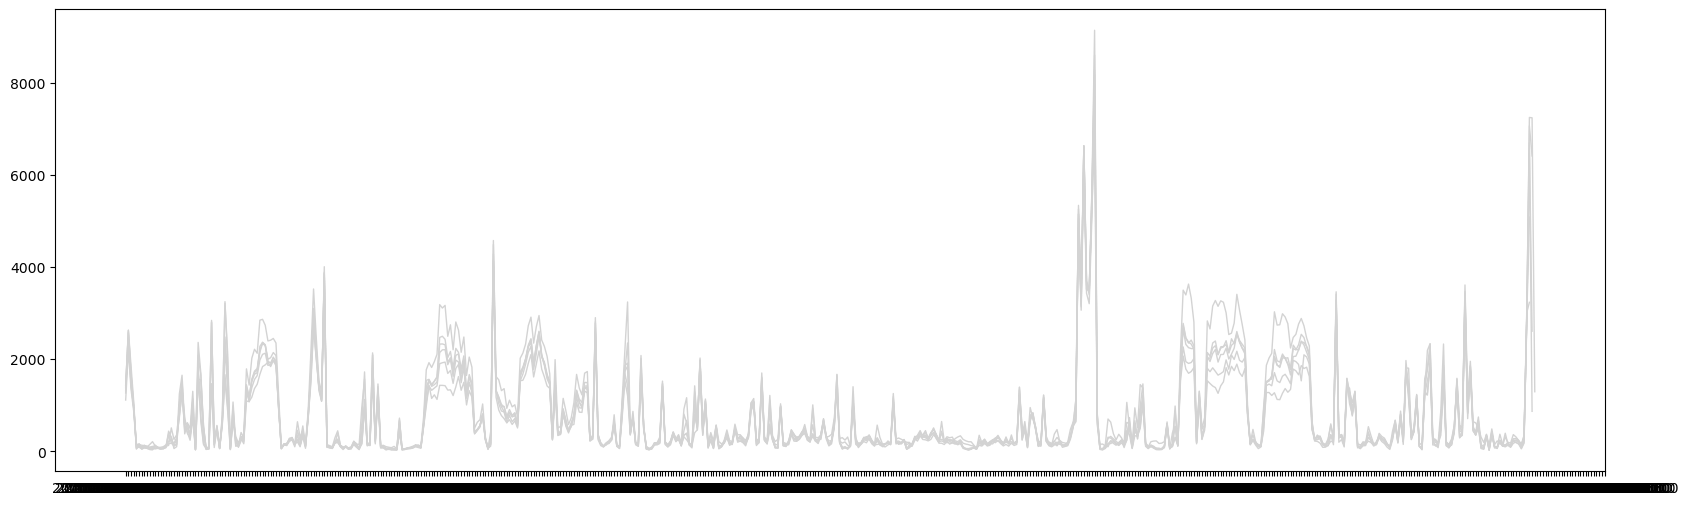

In [38]:
## Plot the number of detections per hour

### Get the subarray
subarray = get_subarray_from_template_name(tempname)

### Get the stations to plot
if subarray == "A":
    stations_plot =  INNER_STATIONS_A
    linecolor =  "dodgerblue"
elif subarray == "B":
    stations_plot = INNER_STATIONS_B
    linecolor = "darkorange"
else:
    raise ValueError("Unknown subarray")

fig, ax = subplots(1, 1, figsize=(20, 6))

if stations_plot[0][0] == "A":
    linecolor =  "dodgerblue"
else:
    linecolor = "darkorange"

### Plot the STA-LTA detections
hours_stalta = staltadf.index
for station in stations_plot:
    counts = staltadf[station]

    ax.plot(hours_stalta, counts, label=station, color="lightgray", linewidth=1)

### Plot the cc detections
hours_cc = ccdf.index
counts = ccdf["count"]
ax.plot(hours_cc, counts, label="cc", color=linecolor, linewidth=2)

time_template = template.first_start_time
hour_template = time_template.replace(minute=0, second=0, microsecond=0)    

ax.axvline(x=hour_template, color=linecolor, linestyle="--", linewidth=2)

ax.set_ylim(0, countmax)

ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Number of detections per hour")

ax.set_title(f"Template: {tempname}", fontsize=12, fontweight="bold")
ax.xaxis.set_minor_locator(DayLocator())

### Save figure
fig.patch.set_alpha(0)

outpath = join(ROOTDIR, timewin, f"cc_vs_stalta_{tempname}_{suffix_cc}_{suffix_sta_lta}.png")
fig.savefig(outpath, dpi=300)
